# Summer School - Modeling Water Fluxes In The Soil-Plant System

## Coupled Soil and Root Hydraulics, including dynamic perirhizal models



In [46]:
import os, sys
sourcedir = os.getcwd()+"/../../../../"
sys.path.append(sourcedir); sys.path.append(sourcedir+"CPlantBox/"); sys.path.append(sourcedir+"CPlantBox/src/")
sys.path.append(sourcedir+"dumux-rosi/python/modules/");
sys.path.append(sourcedir+"dumux-rosi/python/modules/fv/");
sys.path.append(sourcedir+"dumux-rosi/build-cmake/cpp/python_binding/"); 

import plantbox as pb  # CPlantBox
from rosi_richards import RichardsSP
from richards import RichardsWrapper  # Python part, macroscopic soil model
from functional.xylem_flux import *  # root system Python hybrid solver
from rhizo_models import *  # Helper class for cylindrical rhizosphere models

import visualisation.vtk_plot as vp
import functional.van_genuchten as vg
from functional.root_conductivities import *

import numpy as np
import timeit
import matplotlib.pyplot as plt

In [47]:
""" soil """
min_b = [-4., -4., -15.]  # cm
max_b = [4., 4., 0.]  # cm
domain_volume = np.prod(np.array(max_b) - np.array(min_b))
cell_number = [7, 7, 15]  # [8, 8, 15]  # [16, 16, 30]  # [32, 32, 60]  # [8, 8, 15] # [1]
periodic = False
loam = [0.08, 0.43, 0.04, 1.6, 50]
# loam = [0.03, 0.345, 0.01, 2.5, 28.6]
soil_ = loam
soil = vg.Parameters(soil_)
initial = -659.8 + (max_b[2] - min_b[2]) / 2  # -659.8 + 7.5 because -659.8 is the value at the top, but we need the average value in the domain

""" root system """
trans = 6.4  # average per day [cm3 /day] (sinusoidal)
wilting_point = -15000  # [cm]
age_dependent = False  # conductivities
rs_age = 8 

""" rhizosphere models """
mode = "dumux"  # or "dumux"
NC = 10  # dof+1
logbase = 1.5  # according to Mai et al. (2019)
split_type = 1
""" simulation time """
sim_time = 1 #1  # 0.65  # 0.25  # [day]
dt = 30 / (24 * 3600)  # time step [day]
NT = int(np.ceil(sim_time / dt))  # number of iterations
skip = 1  # for output and results, skip iteration

In [48]:
""" 
Initialize macroscopic soil model (Dumux binding)
"""
s = RichardsWrapper(RichardsSP())
s.initialize()

s.createGrid(min_b, max_b, cell_number, periodic)  # [cm]
s.setHomogeneousIC(initial, True)  # cm pressure head, equilibrium
s.setTopBC("noFlux")
s.setBotBC("noFlux")
s.setVGParameters([soil_])
s.setParameter("Newton.EnableAbsoluteResidualCriterion", "True")
s.setParameter("Soil.SourceSlope", "1000")  # turns regularisation of the source term on
s.initializeProblem()
s.setCriticalPressure(wilting_point)  # new source term regularisation
s.ddt = 1.e-5  # [day] initial Dumux time step

""" 
Initialize xylem model 
"""
rs = RhizoMappedSegments(sourcedir+"dumux-rosi/grids/RootSystem8.rsml", wilting_point, NC, logbase, mode)
rs.ms.setRectangularGrid(pb.Vector3d(min_b[0], min_b[1], min_b[2]), pb.Vector3d(max_b[0], max_b[1], max_b[2]),
                        pb.Vector3d(cell_number[0], cell_number[1], cell_number[2]), False, False)
# True: root segments are cut  to the soil grid so that each segment is completely within one soil control element, this works only for rectangular grids so far
picker = lambda x, y, z: s.pick([x, y, z])  #  function that return the index of a given position in the soil grid (should work for any grid - needs testing)
rs.ms.setSoilGrid(picker)  # maps segments, maps root segements and soil grid indices to each other in both directions
r = XylemFluxPython(rs.ms)  # wrap the xylem model around the MappedSegments
init_conductivities(r, age_dependent)  # age_dependent is a boolean, root conductivies are given in the file /root_conductivities.py
rs.set_xylem_flux(r)


No parameter file found. Continuing without parameter file.
Computed bounding box tree with 1469 nodes for 735 grid entities in 0.000476899 seconds.
Computed bounding box tree with 1469 nodes for 735 grid entities in 0.0004388 seconds.
XylemFluxPython.read_rsml: read rsml with 581 nodes and 580 segments
                           cts [0, 7.99695] days
                           raddii [0.0118174, 0.168001] cm
                           subTypes [1, 2] 



In [49]:

""" 
Initialize local soil models (around each root segment) 
"""
start_time = timeit.default_timer()
x = s.getSolutionHead()  # initial condition of soil [cm]
dcyl = len(rs.ms.segments)
rs.initialize(soil_, x, np.array(range(ns)))
print ("Initialized [{:g}-{:g}] in {:g} s".format(0, ns, timeit.default_timer() - start_time))



initializing look up tables
done

DuMux Solver 1D (CCTpfa method) no problem initialized on process rank 1/1

                ##                  @@@@          @   @         @ @
             ###   #                @   @         @@ @@          @ 
           ##       #               @   @  @   @  @ @ @  @   @  @ @
         ##          #              @   @  @   @  @   @  @   @     
        #             #             @@@@    @@@   @   @   @@@      
       #               #                                           
      #                 #                                          
     #                   ##        %%%                          3.8
    #                      ###    %   %  %%     %%                 
####                          #%%%     %%  %%%%%  %%%%%%%%%%%%%%%%%


DuMux Solver 1D (CCTpfa method) no problem initialized on process rank 1/1

                ##                  @@@@          @   @         @ @
             ###   #                @   @         @@ @@         

In [50]:

""" 
Simulation 

loop
1. xylem model
2. local soil models
3. macroscopic soil model 
"""
print("Starting simulation")
start_time = timeit.default_timer()

# for post processing
min_sx, min_rx, min_rsx, collar_sx, collar_flux = [], [], [], [], []  # cm
water_uptake, water_collar_cell, water_cyl, water_domain, solute_uptake = [], [], [], [], []  # cm3
out_times = []  # days
cci = picker(rs.ms.nodes[0].x, rs.ms.nodes[0].y, rs.ms.nodes[0].z)  # collar cell index
cell_volumes = s.getCellVolumes()  # cm3
net_flux = np.zeros(cell_volumes.shape)

for i in range(0, NT):

    wall_iteration = timeit.default_timer()

    t = i * dt  # current simulation time

    """ 1. xylem model """
    wall_root_model = timeit.default_timer()
    rsx = rs.get_inner_heads()  # matric potential at the root soil interface, i.e. inner values of the cylindric models [cm]
    soil_k = np.divide(vg.hydraulic_conductivity(rsx, soil), rs.ms.radii)  # only valid for homogenous soil
    rx = r.solve(rs_age + t, -trans * sinusoidal(t), 0., rsx, False, wilting_point, soil_k)  # [cm]   False means that rsx is given per root segment not per soil cell
    proposed_inner_fluxes = r.segFluxes(rs_age + t, rx, rsx, approx = False, cells = False, soil_k = soil_k)  # [cm3/day]
    wall_root_model = timeit.default_timer() - wall_root_model

    """ 2. local soil models """
    wall_rhizo_models = timeit.default_timer()
    proposed_outer_fluxes = rs.ms.splitSoilFluxes(net_flux / dt, split_type)
    
    rs.solve(dt, proposed_inner_fluxes, proposed_outer_fluxes)  
    
    realized_inner_fluxes = rs.get_inner_fluxes()
    wall_rhizo_models = timeit.default_timer() - wall_rhizo_models

    """ 3a. macroscopic soil model """
    wall_soil_model = timeit.default_timer()
    water_content = np.array(s.getWaterContent())
    soil_water = np.multiply(water_content, cell_volumes)
    soil_fluxes = rs.ms.sumSegFluxes(realized_inner_fluxes)  # [cm3/day]  per soil cell
    s.setSource(soil_fluxes.copy())  # [cm3/day], in richards.py
    s.solve(dt)  # in solverbase.py

    """ 3b. calculate net fluxes """
    water_content = np.array(s.getWaterContent())
    new_soil_water = np.multiply(water_content, cell_volumes)  # calculate net flux
    net_flux = new_soil_water - soil_water  # change in water per cell [cm3]
    for k, root_flux in soil_fluxes.items():
        net_flux[k] -= root_flux * dt

    soil_water = new_soil_water

    wall_soil_model = timeit.default_timer() - wall_soil_model

    wall_iteration = timeit.default_timer() - wall_iteration

    collar_sx.append(s.getSolutionHeadAt(cci))
    min_sx.append(np.min(s.getSolutionHead()))
    water_cyl.append(np.sum(rs.get_water_volume()))  # cm3

    out_times.append(t)
    collar_flux.append(r.collar_flux(rs_age + t, rx, rsx, soil_k, False))
    min_rsx.append(np.min(np.array(rsx)))
    min_rx.append(np.min(np.array(rx)))
    print("Cylindrical model: minimum root soil interface {:g} cm, soil {:g} cm, root xylem {:g} cm".format(min_rsx[-1], min_sx[-1], min_rx[-1]))
    min_soil_fluxes, max_soil_fluxes, summed_soil_fluxes = 1.e9, -1.e9, 0.
    for k, v in soil_fluxes.items():
        summed_soil_fluxes += v
        if max_soil_fluxes < v:
            max_soil_fluxes = v
        if min_soil_fluxes > v:
            min_soil_fluxes = v
    print("Fluxes: summed local fluxes {:g}, collar flux {:g}, predescribed {:g}".format(summed_soil_fluxes, collar_flux[-1], -trans * sinusoidal(t)))
    water_domain.append(np.min(soil_water))  # cm3
    water_collar_cell.append(soil_water[cci])  # cm3
    water_uptake.append(summed_soil_fluxes)  # cm3/day
    n = round(float(i) / float(NT) * 100.)
    print("[" + ''.join(["*"]) * n + ''.join([" "]) * (100 - n) + "], {:g} days".format(s.simTime))
    print("Iteration {:g} took {:g} seconds [{:g}% root, {:g}% rhizo {:g}% soil ]\n".
          format(i, wall_iteration, wall_root_model / wall_iteration*100., wall_rhizo_models / wall_iteration*100., wall_soil_model / wall_iteration*100.))



Starting simulation
Cylindrical model: minimum root soil interface -659.3 cm, soil -659.3 cm, root xylem -659.82 cm
Fluxes: summed local fluxes -1.37227e-12, collar flux -2.56547e-14, predescribed -0
[                                                                                                    ], 0.000347222 days
Iteration 0 took 0.384095 seconds [1.9352% root, 71.806% rhizo 26.2578% soil ]

Cylindrical model: minimum root soil interface -659.314 cm, soil -659.299 cm, root xylem -659.826 cm
Fluxes: summed local fluxes -1.52309e-05, collar flux -1.52309e-05, predescribed -1.52309e-05
[                                                                                                    ], 0.000694444 days
Iteration 1 took 0.205645 seconds [1.47998% root, 65.2853% rhizo 33.233% soil ]

Cylindrical model: minimum root soil interface -659.323 cm, soil -659.299 cm, root xylem -659.842 cm
Fluxes: summed local fluxes -6.09234e-05, collar flux -6.09234e-05, predescribed -6.09234e-05
[      

/home/rbtl2404/cpbenv/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


Cylindrical model: minimum root soil interface -3537.85 cm, soil -876.774 cm, root xylem -15000 cm
Fluxes: summed local fluxes -3.92958, collar flux -3.95592, predescribed -3.97665
[*******************                                                                                 ], 0.188542 days
Iteration 542 took 0.222088 seconds [7.16149% root, 81.7807% rhizo 11.0563% soil ]

Cylindrical model: minimum root soil interface -3537.57 cm, soil -878.006 cm, root xylem -15000 cm
Fluxes: summed local fluxes -3.74991, collar flux -3.75385, predescribed -3.98958
[*******************                                                                                 ], 0.188889 days
Iteration 543 took 0.208307 seconds [4.32497% root, 84.2263% rhizo 11.447% soil ]

Cylindrical model: minimum root soil interface -3489.91 cm, soil -879.21 cm, root xylem -15000 cm
Fluxes: summed local fluxes -3.68413, collar flux -3.7068, predescribed -4.00252
[*******************                                    

Coupled benchmark solved in  32.98314536600083  s


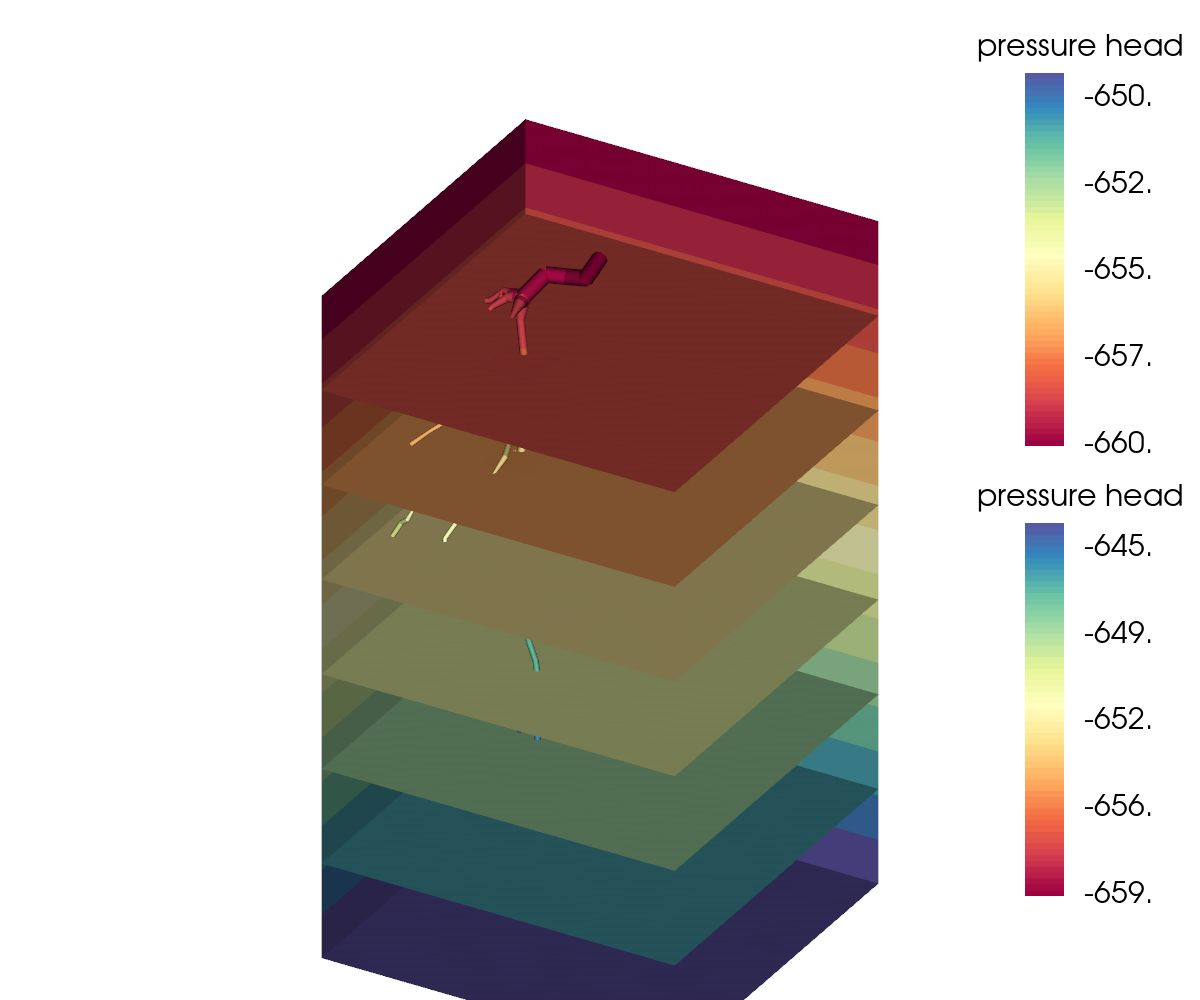

2025-09-03 12:05:22.987 (10190.277s) [    70DDD52A2080]       vtkXMLWriter.cxx:636    ERR| vtkXMLPolyDataWriter (0x35646160): Error opening output file "results/Zeamays_synMRI_modified.vtp"
2025-09-03 12:05:22.987 (10190.277s) [    70DDD52A2080]       vtkXMLWriter.cxx:638    ERR| vtkXMLPolyDataWriter (0x35646160): Error code "No such file or directory"
2025-09-03 12:05:22.987 (10190.277s) [    70DDD52A2080]       vtkExecutive.cxx:729    ERR| vtkCompositeDataPipeline (0x2e03cda0): Algorithm vtkXMLPolyDataWriter (0x35646160) returned failure for request: vtkInformation (0x2fd12890)
  Debug: Off
  Modified Time: 98257
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2025-09-03 12:05:22.987 (10190.278s) [    70DDD52A2080]       vtkXMLWriter.cxx:636    ERR| vtkXMLImageDataWriter (0x2df76390): Error opening output file "results/Zeamays_synMRI_modified.vtu"
2025-09-03 12:05:22.987 (10190.278s)

Cumulative soil uptake 3.6642693060705254e-05 [cm^3]


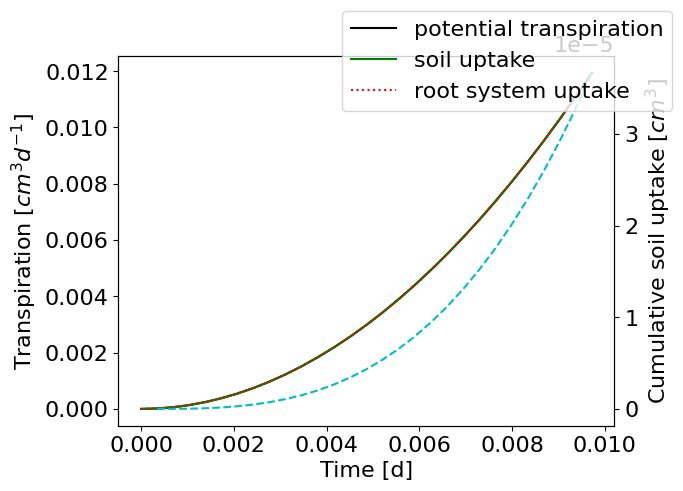

In [44]:

""" plots and output """
if rank == 0:
    print ("Coupled benchmark solved in ", timeit.default_timer() - start_time, " s")
    vp.plot_roots_and_soil(r.rs, "pressure head", rsx, s, periodic, min_b, max_b, cell_number, name, interactiveImage = False)  # VTK vizualisation

    plot_transpiration(out_times, water_uptake, collar_flux, lambda t: trans * sinusoidal(t))  # in rhizo_models.py

